# EGamma short exercise
Photons and electrons play a crucial role in the success of CMS. They were vital in the discovery of the Higgs boson and play an important role in searches for new physics and standard model measurements. The CMS detector features a high-resolution electromagnetic calorimeter (ECAL) and the world's largest active silicon tracker. These detectors provide clean object identification and excellent energy and momentum resolution of photons and electrons. Within CMS, the [EGamma POG](https://twiki.cern.ch/twiki/bin/view/CMS/EgammaPOG) has the responsibility to "study, develop, characterize and validate the tools to identify and reconstruct electrons and photons." In this exercise, we will examine photon and electron identification and study how these objects are used in physics analyses. We will start with [NanoAOD](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookNanoAOD) samples.

Table of contents:
   * [Using NanoAOD](#Using-NanoAOD)
   * [Array programming primer](#Array-programming-primer)
   * [Ground truth](#Ground-truth)
   * [Discriminating variables](#Discriminating-variables)
      * [Shower shape](#Shower-shape)
      * [Isolation](#Isolation)
      * [Electron-specific variables](#Electron-specific-variables)
      * [Photon-specific variables](#Photon-specific-variables)
   * [Cut optimization](#Cut-optimization)
   * [Tag and probe](#Tag-and-probe)
   * [Scale Factors](#Scale-Factors)

## Using NanoAOD
We will be using the [NanoAOD](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookNanoAOD) data format in this exercise. It contains only information that are accessed in a typical CMS analysis, averaging 1-2 kB per event, in basic types like `int`, `float`, etc. This is in contrast to the [EDM format](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookCMSSWFramework#EdM) used in upstream formats. This means that no CMSSW environment is necessary to read NanoAOD files.

For analyses that require information not available in standard NanoAOD, one can create _private NanoAOD_, where  missing variables and/or CMSSW framework modules are added to the [configuration](https://github.com/cms-sw/cmssw/blob/master/PhysicsTools/NanoAOD/python/nano_cff.py) and then CRAB workflows are used to re-extract the information from the parent MiniAOD dataset.  The CMS [cross-POG forum](https://indico.cern.ch/category/5517/) exists to also allow users to petition for certain variables to be added to central NanoAOD.  For the purposes of this exercise, all standard EGamma variables can already be found in NanoAOD.

Below, we examine the content of a NanoAOD file using [uproot](https://uproot.readthedocs.io/en/latest/?badge=latest#).

In [1]:
import uproot
from glob import glob

base_directory = "/eos/user/c/cmsdas/2024/short-ex-egm/datasets/"
dyfiles = sorted(
    glob(
        f"{base_directory}DYto2L-2Jets_MLL-50_TuneCP5_13p6TeV-amcatnloFXFX-pythia8/*.root"
    )
)
gjetfiles = sorted(
    glob(
        f"{base_directory}GJ-4Jets_HT-400to600_TuneCP5_13p6TeV_madgraphMLM-pythia8/*.root"
    )
)
datafiles = sorted(glob(f"{base_directory}EGamma1_Run2023C/*.root"))
file = uproot.open(dyfiles[0])
dict(file)

{'tag;1': <TObjString 'untagged' at 0x7ff5dc3bc4a0>,
 'Events;1': <TTree 'Events' (1782 branches) at 0x7ff5dc3c5df0>,
 'LuminosityBlocks;1': <TTree 'LuminosityBlocks' (6 branches) at 0x7ff5dc3c5ca0>,
 'Runs;1': <TTree 'Runs' (10 branches) at 0x7ff5dc3c5970>,
 'MetaData;1': <TTree 'MetaData' (1 branches) at 0x7ff5dc3c5700>,
 'ParameterSets;1': <TTree 'ParameterSets' (1 branches) at 0x7ff514c52970>}

The item of interest here is the `Events` [TTree](https://root.cern.ch/doc/master/classTTree.html) object. We will focus on electron/photon specific content. More information about the entire `Events` tree can be found in [this website](https://cms-nanoaod-integration.web.cern.ch/integration/master-106X/mc106X_doc.html) (and its' parent folder contains branch lists for other NanoAOD versions).

To help organize all this content, we'll use the [coffea](https://coffeateam.github.io/coffea/) NanoEvents class.

In [2]:
from coffea.nanoevents import NanoEventsFactory

dyevents = NanoEventsFactory.from_root(dyfiles[0]).events()
gevents = NanoEventsFactory.from_root(gjetfiles[0]).events()
dataevents = NanoEventsFactory.from_root(datafiles[0]).events()

In [3]:
dyevents.Electron.fields

['seediEtaOriX',
 'convVeto',
 'cutBased',
 'cutBased_HEEP',
 'isPFcand',
 'jetNDauCharged',
 'lostHits',
 'mvaIso_WP80',
 'mvaIso_WP90',
 'mvaNoIso_WP80',
 'mvaNoIso_WP90',
 'seedGain',
 'tightCharge',
 'jetIdx',
 'photonIdx',
 'svIdx',
 'fsrPhotonIdx',
 'charge',
 'pdgId',
 'seediPhiOriY',
 'vidNestedWPBitmap',
 'vidNestedWPBitmapHEEP',
 'deltaEtaSC',
 'dr03EcalRecHitSumEt',
 'dr03HcalDepth1TowerSumEt',
 'dr03TkSumPt',
 'dr03TkSumPtHEEP',
 'dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'eInvMinusPInv',
 'energyErr',
 'eta',
 'hoe',
 'ip3d',
 'jetPtRelv2',
 'jetRelIso',
 'mass',
 'miniPFRelIso_all',
 'miniPFRelIso_chg',
 'mvaHZZIso',
 'mvaIso',
 'mvaNoIso',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'pt',
 'r9',
 'scEtOverPt',
 'sieie',
 'sip3d',
 'mvaTTH',
 'genPartFlav',
 'genPartIdx',
 'genPartIdxG',
 'jetIdxG',
 'photonIdxG']

Try replacing the above cell with `dyevents.Electron.fields` and `dyevents.Photon.fields` to see what photon-related columns exist in the tree.

Below shows how to see a short description of a column. Try `dyevents.Electron.jetIdx.__doc__` and `dyevents.Electron.lostHits.__doc__`. **Q: What could these values be used for? Why are they associated with an electron?**

In [4]:
dyevents.Electron.jetIdx.__doc__

'index of the associated jet (-1 if none)'

## Array programming primer

Before diving into the content, let's give a quick overview of [awkward](https://awkward-array.org/quickstart.html) array syntax, as the NanoEvents structure is an awkward array.  It is an extension of the [numpy](https://numpy.org/) array programming syntax.  If you are unfamiliar with numpy, perhaps glance through the [numpy quickstart](https://docs.scipy.org/doc/numpy/user/quickstart.html) before continuing, in particular the universal function and boolean indexing sections.  The main extensions to numpy that are used here are jagged arrays.  Some basic properties are shown below.

In [5]:
import awkward as ak
import numpy as np

a = ak.Array([[1, 2, 3], [4, -2, 4], [], [5]])
print(repr(a))
print(repr(ak.num(a)))

<Array [[1, 2, 3], [4, -2, 4], [], [5]] type='4 * var * int64'>
<Array [3, 3, 0, 1] type='4 * int64'>


Above is a singly-jagged array, where the first dimension has length 4, and the second dimension has variable length.  The length along that dimension is accessible via the [ak.num function](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html) (the default axis is 1 for `ak.num`).  This is like the array `dyevents.Electrons`.  All comparison operators and numpy ufuncs are _broadcast_ over the content, meaning they are applied to each element in the jagged array. For example:

In [6]:
print(a > 2)
print(abs(a))

[[False, False, True], [True, False, True], [], [True]]
[[1, 2, 3], [4, 2, 4], [], [5]]


The jagged array `a > 2` can be used to filter (i.e. select) only those elements that pass the criteria. This is done using the `array[filter]` notation. We will use this syntax later to, for example, select only electrons above a certain pT threshold:

In [7]:
object_cut = a > 2
print(object_cut)
print(a[object_cut])

[[False, False, True], [True, False, True], [], [True]]
[[3], [4, 4], [], [5]]


When using jagged arrays in a typical physics analysis, in addition to `object_cuts` we can also have event-level selections. For example, we might want to only select _events_ where `all` electrons in the event have pT above some threshold:

In [8]:
event_cut = ak.all(a > 2, axis=1)
print(event_cut)
print(a[event_cut])

[False, False, True, True]
[[], [5]]


Most utilities in the scientific python "speak" numpy arrays, however they do not know about jagged arrays.  So, for example, when interfacing with [pandas](https://pandas.pydata.org/) or [matplotlib](https://matplotlib.org/) we need to remove the jaggedness by using `ak.flatten`.  Of course, we should do this only after making any event-level selections, as after flattening, that structure is lost.

In [9]:
print(a[event_cut])
print(ak.flatten(a[event_cut]))

[[], [5]]
[5]


Another common awkward type is masked arrays.  The main feature is that certain elements can be [null](https://en.wikipedia.org/wiki/Nullable_type) (syn. N/A, not available, `None`)

In [10]:
b = ak.Array([1, 2, None, 4])
b

<Array [1, 2, None, 4] type='4 * ?int64'>

The null value propagates through any operation, until it is filled in

In [11]:
print(b)
print(ak.fill_none(b, -1))
print(b > 0)
print(ak.fill_none(b, -1) > 0)

[1, 2, None, 4]
[1, 2, -1, 4]
[True, True, None, True]
[True, True, False, True]


In the scientific python ecosystem, [matplotlib](https://matplotlib.org/) is the de facto standard plotting utility. Let's import it, along with [mplhep](https://mplhep.readthedocs.io/en/latest/), a helper library to make HEP plots easier (including CMS style!).

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep

mplhep.style.use(mplhep.style.CMS)

In [13]:
# run this again to make sure the figure size updates (a known bug)
mplhep.style.use(mplhep.style.CMS)

## Kinematics
Below is a plot of all reconstructed electrons' transverse momentum ($p_{T}$) in the DY (Drell-Yan) NanoAOD file.
Try plotting instead the $\eta$ or $\phi$ of the electrons, or the electron `counts`, or the $p_{T}$ of the electrons after applying a cut on $|\eta| < 1.4$.

(array([0.0000e+00, 8.0460e+04, 5.1750e+04, 3.8860e+04, 3.7192e+04,
        3.8679e+04, 4.0664e+04, 4.3124e+04, 4.5252e+04, 4.7711e+04,
        4.7359e+04, 3.5047e+04, 2.0447e+04, 1.3112e+04, 9.4710e+03,
        7.1660e+03, 5.5530e+03, 4.3480e+03, 3.5120e+03, 2.7150e+03,
        2.2050e+03, 1.7690e+03, 1.5080e+03, 1.2480e+03, 1.0300e+03,
        8.6300e+02, 7.4400e+02, 6.0900e+02, 5.1700e+02, 4.9100e+02,
        3.9300e+02, 3.3900e+02, 2.9600e+02, 2.8100e+02, 2.0900e+02,
        2.1000e+02, 1.8800e+02, 1.4700e+02, 1.6200e+02, 1.2200e+02,
        1.1600e+02, 1.0800e+02, 1.1200e+02, 1.0200e+02, 7.9000e+01,
        6.2000e+01, 5.8000e+01, 7.0000e+01, 5.2000e+01]),
 array([  0.        ,   4.08163265,   8.16326531,  12.24489796,
         16.32653061,  20.40816327,  24.48979592,  28.57142857,
         32.65306122,  36.73469388,  40.81632653,  44.89795918,
         48.97959184,  53.06122449,  57.14285714,  61.2244898 ,
         65.30612245,  69.3877551 ,  73.46938776,  77.55102041,
         8

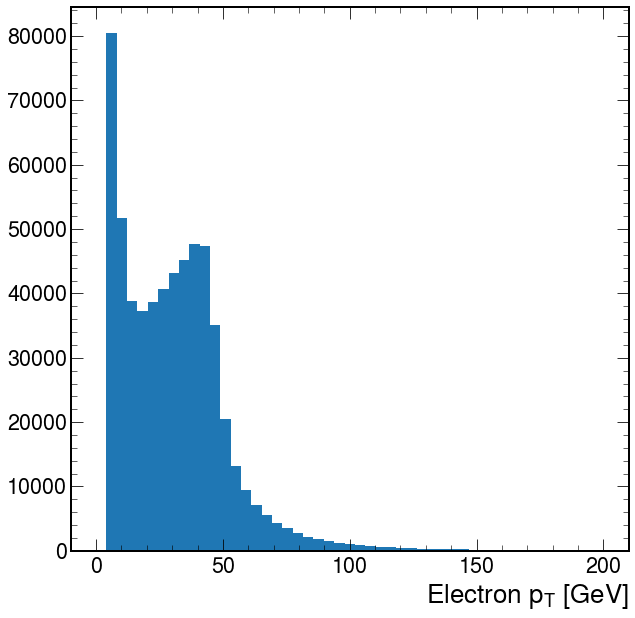

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel(r"Electron $p_{T}$ [GeV]")
ax.hist(ak.flatten(dyevents.Electron.pt), bins=np.linspace(0, 200, 50))
# ax.set_xlabel(r'Electron $\eta$')
# ax.hist(ak.flatten(dyevents.Electron.eta), bins = np.linspace(-2.5, 2.5, 50))

Below we plot the invariant mass of all distinct pairs of electrons. The pairs made using the `combinations` function ([documentation](https://awkward-array.org/doc/main/reference/generated/ak.combinations.html)). The `e0` and `e1` names are names we assign so we can separately access the first and second electron in the pair. **Q: What is the origin of the shoulder-like structure at low mass? Can this be removed by performing selections on the electron candidates, using the information above?**

[[], [0.958], [], [], [], [], [1.03], ... [], [], [], [0.944, 0.959], [], [], []]
[True, False, True, True, True, True, True, ... True, True, False, True, True, True]
[<event 1:16000:42013385>, <event 1:16000:42013375>, ... <event 1:194745:511400366>]


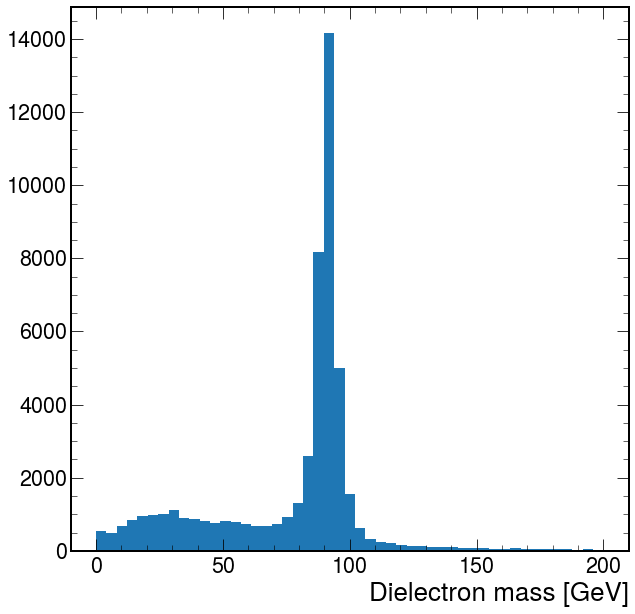

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel(r"Dielectron mass [GeV]")
event_cut = ak.all(dyevents.Electron.r9 > 0.96, axis=1)
print(dyevents.Electron.r9)
print(event_cut)
print(dyevents[event_cut])
# ee = ak.combinations(dyevents.Electron, 2, fields = ["e0", "e1"])
ee = ak.combinations(dyevents[event_cut].Electron, 2, fields=["e0", "e1"])
mass = (ee.e0 + ee.e1).mass
ax.hist(ak.flatten(mass), bins=np.linspace(0, 200, 50));

## Ground truth
If we want to identify variables useful in distinguishing electrons and photons candidates, we better have a good definition of "true".  Let's take a look at the generated particles that are matched to reconstructed electrons and photons to understand what kind of processes give rise to them.

For electrons and photons, NanoAOD pre-computes the truth-matched particle by finding final-state electron and photon particles in the `GenPart` table that are directionally close (via the metric $\Delta R = \sqrt{(\Delta \eta)^2 + (\Delta \phi)^2}$) and $\Delta p_{\mathrm{T}}/p_{\mathrm{T}}$ to the reconstructed particle.  When no match is found, we get a -1 value.  Below, we put reconstructed electrons into three buckets: matched to a gen electron, matched to a gen photon, and unmatched, based on the [PDG id](http://pdg.lbl.gov/2018/reviews/rpp2018-rev-monte-carlo-numbering.pdf).  Since for this purpose we don't care so much which event each electron belongs to, we also flatten the array here for convenience.

In [16]:
electrons = ak.flatten(dyevents.Electron)

true_electrons = electrons[ak.fill_none(abs(electrons.matched_gen.pdgId) == 11, False)]
photon_fakes = electrons[ak.fill_none(electrons.matched_gen.pdgId == 22, False)]
unmatched_electrons = electrons[ak.is_none(electrons.matched_gen)]

For the true electrons, we would expect the parent to be a Z boson in these samples.  We can check this using the `distinctParent` attribute stored in our files.  There is also a `parent` attribute, which specifies the direct ancestor to the generated electron, however this could also be an electron (due to final state $\gamma$ radiation and other generator-internal reasons).  The `distinctParent` attribute skips copies of the same particle that are the result of FSR.

Below, we put the `distinctParent` value, along with some other (carefully chosen) gen particle flags, into a pandas dataframe by passing a dictionary. In this dictionary, the key signifies the parameter and the element is a flattened array of that value for every electron in the NanoAOD file. The `ak.zip` groups keyed elements together for each electron, making sure the dataframe is cast correctly where each electron is an entry. We then use `groupby` to create categories that share common values. They are then ranked by the number of electrons, or "counts" that are in that category. We only consider the categories with the top 10 number of entries.

In [17]:
df = ak.to_pandas(
    ak.zip(
        {
            "parentId": abs(true_electrons.matched_gen.distinctParent.pdgId),
            "fromHardProcess": true_electrons.matched_gen.hasFlags(["fromHardProcess"]),
            "isPrompt": true_electrons.matched_gen.hasFlags(["isPrompt"]),
            "isDirectPromptTauDecayProduct": true_electrons.matched_gen.hasFlags(
                ["isDirectPromptTauDecayProduct"]
            ),
        }
    )
)

top10 = (
    df.groupby(list(df.columns))
    .size()
    .rename("count")
    .reset_index()
    .sort_values("count", ascending=False)
)[:10]

top10

,parentId,fromHardProcess,isPrompt,isDirectPromptTauDecayProduct,count
19,23.0,True,True,False,367191
14,15.0,False,False,True,44683
3,2.0,True,True,False,10583
17,21.0,True,True,False,3657
0,1.0,True,True,False,2932
8,4.0,True,True,False,2260
6,3.0,True,True,False,1359
30,521.0,False,False,False,733
29,511.0,False,False,False,662
25,411.0,False,False,False,628


Indeed, in most cases, the parent is pdgId `23`, corresponding to the Z boson.  Sometimes the parent is a $\tau$ lepton, and then the remainder are cases where the electron is from a hadron decay (`parentId > 100`) or where the parentage appears somewhat suspect (e.g. pdg IDs less than 6, corresponding to bare quarks... this is a quirk in how MadGraph records the parentage history for off-shell $Z^*/\gamma^*$).  Conveniently, a set of flags is embedded in NanoAOD that are more straightforward than traversing the NanoAOD parentage history.  In our case, we'll take `isPrompt` as the marker for true electrons coming from the hard scatter event.  Since direct $\tau$ decays produce prompt isolated electrons, we include those with `isDirectPromptTauDecayProduct` as well.

In [18]:
promptmatch = true_electrons.matched_gen.hasFlags(["isPrompt"])
promptmatch = promptmatch | true_electrons.matched_gen.hasFlags(
    ["isDirectPromptTauDecayProduct"]
)
prompt_electrons = true_electrons[promptmatch]
nonprompt_electrons = true_electrons[~promptmatch]

There is also a pre-computed variable `Electron.genPartFlav`, which according to the documentation, has the assignment:

In [19]:
dyevents.Electron.genPartFlav.__doc__

'Flavour of genParticle (DressedLeptons for electrons) for MC matching to status==1 electrons or photons: 1 = prompt electron (including gamma*->mu mu), 15 = electron from prompt tau, 22 = prompt photon (likely conversion), 5 = electron from b, 4 = electron from c, 3 = electron from light or unknown, 0 = unmatched'

Let's see how this compares to our analysis: below we count the number of occurrences of each flavor using [np.unique](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html) and then print the results.

In [20]:
flavors, counts = np.unique(
    ak.to_numpy(prompt_electrons.genPartFlav), return_counts=True
)
for flavor, count in zip(flavors, counts):
    print("GenPart flavor % 3d has % 8d occurrences" % (flavor, count))

GenPart flavor   1 has   388641 occurrences
GenPart flavor  15 has    44683 occurrences
GenPart flavor  22 has        2 occurrences


Try checking our other categories against this pre-computed ground truth categorization by switching out the `prompt_electrons` variable with the others.
For photons, `gevents.Photon.genPartFlav` provides similar categorization.  Below, we use this variable to sort photons into two variables.

In [21]:
photons = ak.flatten(gevents.Photon)
prompt_photons = photons[photons.genPartFlav == 1]
unmatched_photons = photons[photons.genPartFlav == 0]

## Identification variables
In the following few cells, we'll introduce typical identification variables that are useful in distinguishing electrons and photon candidates that are produced in hard scattering processes (the so-called true electrons/photons in HEPese).  We'll also look at electron- and photon-specific identification variables.

### Shower shape

Shower shape variables are constructed from the energy-weighted spatial distribution of ECAL and HCAL deposits.

   * $\sigma_{i\eta i\eta}$ (`Electron.sieie`) is the energy-weighted standard deviation of integer eta (one per crystal) within the 5×5 crystal cluster centered at the crystal with maximum energy:

$$ \sigma_{i\eta i\eta} = \frac{\sum_{i}^{5x5} w_i (i\eta_i - i\eta_{\text{seed}})}{\sum_i^{5x5} w_i}, \quad w_i = \max(0, 4.7 + \ln E_i - \ln E_{5x5}),$$

where the sum runs over the 5 × 5 crystal matrix around the most energetic crystal in the supercluster, and the eta distances are measured in units of the crystal size in the eta direction. This variable represents the second moment of the energy distribution along the eta coordinate.  The integer values are scaled by the nominal crystal $\phi$ width in the barrel which is $\pi / 180 \approx 0.0175$. See: [definition](https://github.com/cms-sw/cmssw/blob/master/RecoEcal/EgammaCoreTools/interface/EcalClusterLazyTools.h#L284-L291) and [implementation](https://github.com/cms-sw/cmssw/blob/master/RecoEcal/EgammaCoreTools/interface/EcalClusterTools.h#L1035-L1126) in CMSSW.

   * $R_9$ (`Electron.r9`) is the ratio of the energy deposited in ECAL inside a 3 × 3 crystal matrix centered on the most energetic crystal in the supercluster and the supercluster raw energy.

   * $H/E$ (`Electron.hoe`) is the ratio of the energy deposited in the single closest HCAL tower to the supercluster position inside a cone of radius 0.15 in the $\eta, \phi$ plane centered on the electron direction and the energy deposited in ECAL to that supercluster.

   * $1/E - 1/P$ (`Electron.eInvMinusPInv`) is the signed difference between the reciprocal of the supercluster energy and the reciprocal of the GSF track momentum.

Below, we plot the $\sigma_{i\eta i\eta}$ variable for true prompt electrons and unmatched electrons, where the minimum electron $p_{T}$ is required to be at least 20 GeV.

Text(1, 0, 'Electron $\\sigma_{i \\eta i \\eta}$')

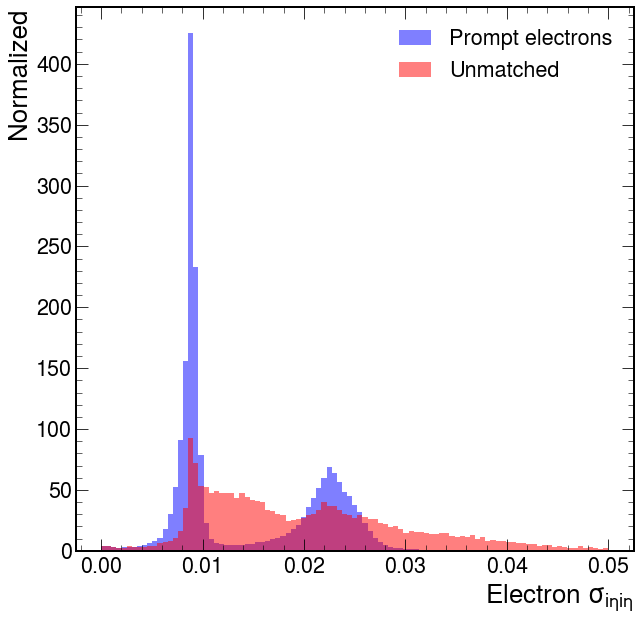

In [22]:
fig, ax = plt.subplots()
opts = {
    "density": True,
    "alpha": 0.5,
}

vars = {
    "sieie": {
        "bins": np.linspace(0, 0.05, 100),
        "xlabel": r"Electron $\sigma_{i \eta i \eta}$",
        "log": False,
    },
    "eInvMinusPInv": {
        "bins": np.linspace(-0.2, 0.2, 100),
        "xlabel": r"Electron $1/E - 1/P$ [/GeV]",
        "log": True,
    },
    "r9": {"bins": np.linspace(0, 1, 100), "xlabel": r"Electron $R_{9}$", "log": True},
    "hoe": {"bins": np.linspace(0, 1, 100), "xlabel": r"Electron H/E", "log": True},
    "pfRelIso03_chg": {
        "bins": np.linspace(0, 1, 100),
        "xlabel": r"Electron relative charged isolation",
        "log": True,
    },
}


def cut_and_get(candidates, attribute):
    return getattr(candidates[(candidates.pt > 20.0)], attribute)


var = "sieie"
ax.hist(
    cut_and_get(prompt_electrons, var),
    color="blue",
    label="Prompt electrons",
    bins=vars[var]["bins"],
    **opts,
)
# ax.hist(cut_and_get(photon_fakes, var), color = 'green', label = 'Photons', bins = vars[var]['bins'], **opts)
# ax.hist(cut_and_get(nonprompt_electrons, var), color = 'orange', label = 'Non-prompt electrons', bins = vars[var]['bins'], **opts)
ax.hist(
    cut_and_get(unmatched_electrons, var),
    color="red",
    label="Unmatched",
    bins=vars[var]["bins"],
    **opts,
)

ax.legend()
ax.set_ylabel("Normalized" if opts["density"] else "Events")
ax.set_yscale("log" if vars[var]["log"] else "linear")
ax.set_xlabel(vars[var]["xlabel"])

Try uncommenting different categories and looking at the distributions.  Any guess as to why the true electrons have a double-peak?  It might help to try looking at `sieie` separately for barrel and endcap reconstructed electrons (hint: modify the filter function to also require `abs(electrons.eta) < 1.4447` for barrel electrons, and `abs(electrons.eta) > 1.566` for endcap).

**Look at R9, H/E and 1/E - 1/P variables.** Which of the three offers the strongest true vs fake electron discrimination? **Is the sign of (1/E - 1/P) relevant for identification purposes?**

Look at each variable as a function of $p_{T}$, for example by plotting a 2D histogram.  What trends do you notice?

Plot `sieie` for prompt and unmatched photons in the barrel. Do you notice anything interesting?

## Isolation

Isolation variables compare the amount of energy deposited in a region around the reconstructed object to that of the object.  Typically, non-prompt electrons and photons (i.e. from hadron decays) have other energy deposited nearby.  Two particle flow (PF) isolation variables are saved in NanoAOD:

   * PF charged hadron isolation `pfRelIso03_chg`: sum of $p_{T}$ of PF charged hadrons which are associated to the primary vertex, not in the "footprint" of the candidate, and within a cone of $\Delta R < 0.3$,
   * PF total isolation `pfRelIso03_all`: sum of $p_{T}$ of all PF candidates within the cone of $\Delta R < 0.3$,
   
where in both cases, the values are relative to the object $p_{T}$.

Due to pileup (multiple collisions in the same event), some of the PF candidates within this isolation cone may belong to a different collision and therefore this variable has a mild dependence on the number of pileup interactions. This pileup-dependence of total isolation can be corrected for, for example by computing,

$$I = I_{\text{raw}} - \rho * \text{EA}(|\eta|),$$

where $\rho$ is the median pileup energy density per unit area, a measure of the pileup activity in the event (computed during the jet clustering stage); and EA is the effective area of the electron or photon object, a quantity computed and [made available](https://github.com/cms-sw/cmssw/blob/master/RecoEgamma/ElectronIdentification/data/Run3_Winter22/effAreaElectrons_cone03_pfNeuHadronsAndPhotons_122X.txt) by the Egamma POG, and is defined as explained in [slide 4 here](https://indico.cern.ch/event/1204275/contributions/5064343/attachments/2529616/4355064/Electron_cutbasedID_preliminaryID.pdf). **Q: Why is the EA parametrized as a function of $\eta$, instead of say, $\phi$? Can you offer an explanation?**

### Electron-specific variables

   * Mini-isolation `miniPFRelIso_all, miniPFRelIso_chg`: uses a cone whose size varies as a function of the electron $p_{T}$ in order to reduce accidental overlap from hard scatter and pileup processes.
   * Conversion veto `convVeto`: reject electrons that are from photons conversions in the innermost layers of the pixel or tracker detectors.

### Photon-specific variables

   * Conversion-safe electron veto `electronVeto`: this cut replaces the detector-based `pixelSeed` used to distinguish between photons and electrons. It checks the $\Delta R$ distance between the photon direction and the nearest electron track and remove photons if there is a electron matching to the photon supercluster, with no missing hits and having no matching reconstructed conversion.

## Cut optimization

Now that we've seen a few discriminating variables, let's compare their power for differentiating true electrons from background using a [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), which shows signal tagging efficiency as well as background rejection efficiency simultaneously on a 2D plot. Efficiency $\epsilon$ is defined for a given selection as:

$$\epsilon = \frac{n_{\text{pass}}}{n_{\text{pass}}+n_{\text{fail}}} = \frac{n_{\text{pass}}}{n_{\text{total}}}$$

In [23]:
from IDTools.DrawSlider import make_slider

make_slider(prompt_electrons, unmatched_electrons)

Signal Efficiency: 0.75
Background Efficiency: 0.22


Output()

Below we plot the ROC curve for: selected discriminating variables; working points in the ROC of the POG-supported cut-based ID, which is a tuned selection on multiple variables; and the ROC for the POG-supported MVA classifier. Information on all of the POG-supported IDs can be found [here](https://twiki.cern.ch/twiki/bin/view/CMS/EgammaIDRecipesRun2).

**Define a selection on multiple variables, measure its signal and background efficiency, and place a marker on the ROC corresponding to your ID.**

In [24]:
def makeroc(sig, bkg, binning, direction=1):
    """Given a signal and background discriminant array, along with a binning,
    compute the ROC curve by integrating discriminant histograms along a direction:
         1: cut < value
        -1: cut >= value
    Returns a tuple of (signal efficiency, background efficiency)"""
    sighist, _ = np.histogram(ak.to_numpy(sig), bins=binning)
    bkghist, _ = np.histogram(ak.to_numpy(bkg), bins=binning)
    # numpy histogram will ignore values out of range of our binning (overflow)
    # so add the overflow values that would pass given our cut direction
    if direction == 1:
        sighist[0] += sum(sig < binning[0])
        bkghist[0] += sum(bkg < binning[0])
    elif direction == -1:
        sighist[-1] += sum(sig > binning[-1])
        bkghist[-1] += sum(bkg > binning[-1])
    else:
        raise ValueError("Invalid direction")
    sigpass = (np.cumsum(sighist[::direction]) / len(sig))[::direction]
    bkgpass = (np.cumsum(bkghist[::direction]) / len(bkg))[::direction]
    return (sigpass, bkgpass)


def cut(electrons):
    return electrons[(electrons.pt > 20) & (abs(electrons.eta) < 1.4447)]


roc_sieie = makeroc(
    sig=cut(prompt_electrons).sieie,
    bkg=cut(unmatched_electrons).sieie,
    binning=np.linspace(0.005, 0.02, 100),
    direction=1,
)

roc_hoe = makeroc(
    sig=cut(prompt_electrons).hoe,
    bkg=cut(unmatched_electrons).hoe,
    binning=np.linspace(-0.01, 1, 100000),
    direction=1,
)

roc_mva = makeroc(
    sig=cut(prompt_electrons).mvaIso,
    bkg=cut(unmatched_electrons).mvaIso,
    binning=np.linspace(-1, 1, 10000000),
    direction=-1,
)

In [25]:
sig_pass = cut(prompt_electrons).cutBased >= prompt_electrons.LOOSE
bkg_pass = cut(unmatched_electrons).cutBased >= prompt_electrons.LOOSE
wp_cutbased_loose = (
    sum(sig_pass) / len(sig_pass),
    sum(bkg_pass) / len(bkg_pass),
)

sig_pass = cut(prompt_electrons).cutBased >= prompt_electrons.TIGHT
bkg_pass = cut(unmatched_electrons).cutBased >= prompt_electrons.TIGHT
wp_cutbased_tight = (
    sum(sig_pass) / len(sig_pass),
    sum(bkg_pass) / len(bkg_pass),
)

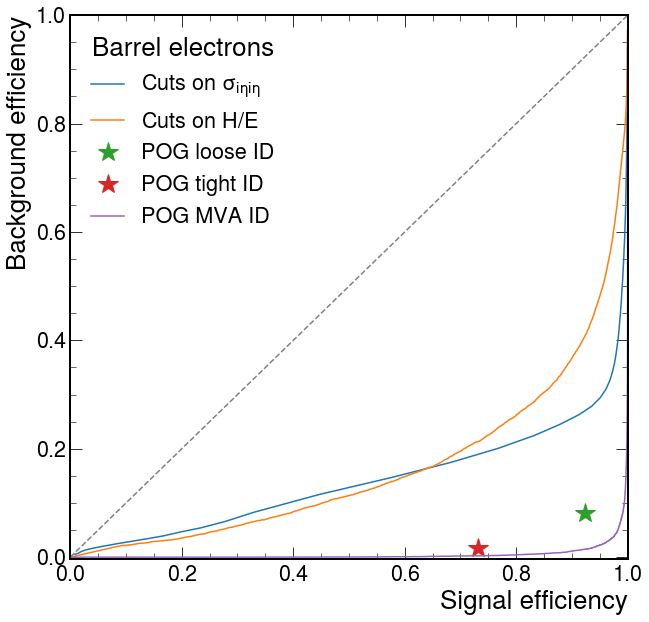

In [26]:
fig, ax = plt.subplots()
ax.plot(*roc_sieie, label=r"Cuts on $\sigma_{i\eta i\eta}$")
ax.plot(*roc_hoe, label=r"Cuts on $H/E$")
ax.plot(
    *wp_cutbased_loose,
    label=r"POG loose ID",
    marker="*",
    markersize=20,
    linestyle="none",
)
ax.plot(
    *wp_cutbased_tight,
    label=r"POG tight ID",
    marker="*",
    markersize=20,
    linestyle="none",
)
ax.plot(*roc_mva, label=r"POG MVA ID")

diag = np.linspace(0, 1, 100)
ax.plot(diag, diag, color="grey", linestyle="--")
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background efficiency")
ax.set_xlim(-0.001, 1.0)
ax.set_ylim(-0.003, 1.0)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend(title=r"Barrel electrons")

We are also often interested in the efficiency as a function of the electron's kinematics. To help explore the dependency, we can record the number of electrons passing and failing a given selection separately for many small regions in the electron $p_{T}$ and $\eta$, which will allow us to compute the (binned) efficiency as a function of these variables, $\epsilon(p_{T}, \eta)$. We are using the [hist](https://hist.readthedocs.io/en/latest/) package to make a multidimensional histogram to record all these values in one object, which later can be projected as necessary.

In [27]:
import hist

efficiency = hist.Hist(
    hist.axis.StrCategory(["pass", "fail"], name="region", label="Region"),
    hist.axis.Regular(18, 20, 200, name="pt", label=r"pt"),
    hist.axis.Regular(25, -2.5, 2.5, name="eta", label=r"eta"),
)

passing = prompt_electrons.cutBased >= prompt_electrons.TIGHT
efficiency.fill(
    region="pass", pt=prompt_electrons[passing].pt, eta=prompt_electrons[passing].eta
)
efficiency.fill(
    region="fail", pt=prompt_electrons[~passing].pt, eta=prompt_electrons[~passing].eta
)

efficiency

Hist(
  StrCategory(['pass', 'fail'], name='region', label='Region'),
  Regular(18, 20, 200, name='pt'),
  Regular(25, -2.5, 2.5, name='eta'),
  storage=Double()) # Sum: 323335.0 (433326.0 with flow)

In the cell below, we project the histogram to recover the binned $n_{\text{pass}}(p_{T})$ (as `num`) and the binned $n_{\text{total}}(p_{T})$ (as `denom`) and plot the ratio $\epsilon(p_{T})$. Modify which axis the histogram is projected onto to see the efficiency as a function of $\eta$.
**Q: is the efficiency symmetric in $\eta$?**
**Q: what might explain the lower efficiency near $|\eta|=1.4$?**

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


Text(0, 1, '$\\epsilon$')

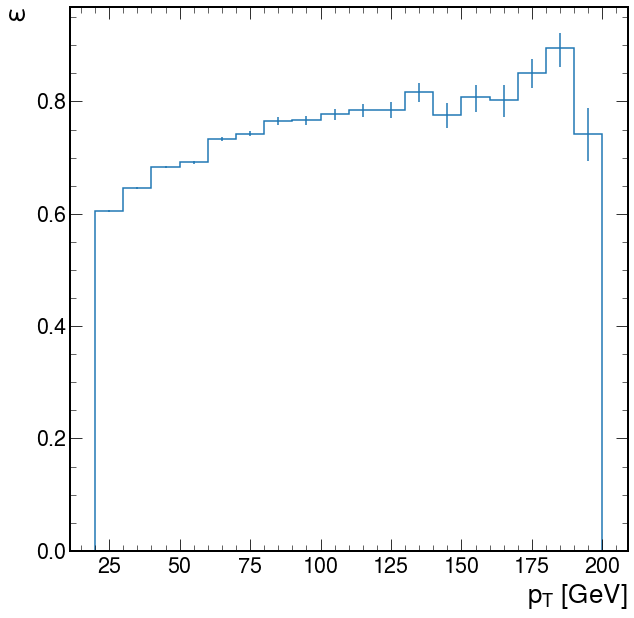

In [28]:
from coffea.hist import clopper_pearson_interval

num = efficiency["pass", ...].project("pt").view()
denom = efficiency.project("pt").view()
edges = efficiency.axes["pt"].edges
err = abs(clopper_pearson_interval(num, denom) - num / denom)

fig, ax = plt.subplots()
mplhep.histplot(num / denom, bins=edges, yerr=err, ax=ax)
ax.set_xlabel("$p_{T}$ [GeV]")
ax.set_ylabel("$\epsilon$")

## Tag and probe

So far, we've computed all our efficiencies using ground truth as provided by our simulation to categorize our signal and background reconstructed electrons.  If we trust our simulation to perfectly describe the detector response, then our job is done.  We cannot do that (**Q: why might we need to know true electron tagging efficiency in data?**), so we need to measure the efficiency in data, categorizing signal and background by inference.  How do we do this without selection bias?  Thanks to the Z boson, we have a solution: tag one electron in an event that passes some high quality requirement, then look for a "probe" electron such that the invariant mass of the di-electron pair ($m_{ee}$) matches that of the Z boson.  If we count the number of probes falling in some mass window that pass and fail our ID, we can infer the true electron tagging efficiency in data, despite not knowing the ground truth for each electron.
Below is a basic example of making a tag and probe selection, then plotting the pass and fail mass distributions, for POG cut-based electron ID, using our simulated Z event sample.

In [29]:
def trigger_match(leptons, trigobjs, pdgid, pt, filterbit):
    """
    Matches leptons with online trigger objects using dR < 0.1 criterion
    The filterbit corresponds to the trigger we want our leptons to have fired
    """
    pass_pt = trigobjs.pt > pt
    pass_id = abs(trigobjs.id) == pdgid
    pass_filterbit = (trigobjs.filterBits & (0x1 << filterbit)) != 0
    trigger_cands = trigobjs[pass_pt & pass_id & pass_filterbit]
    delta_r = leptons.metric_table(trigger_cands)
    pass_delta_r = delta_r < 0.1
    n_of_trigger_matches = ak.sum(pass_delta_r, axis=2)
    trig_matched_locs = n_of_trigger_matches >= 1

    return trig_matched_locs

In [30]:
# select events where Ele30_WPTight_Gsf (an isolated electron with a transverse momentum 𝑝_T > 30 GeV)
good_events = dyevents[dyevents.HLT.Ele30_WPTight_Gsf]

# form all possible dielectron pairs and removing pairs of electrons with themselves
ij = ak.argcartesian([good_events.Electron, good_events.Electron])
is_not_diag = ij["0"] != ij["1"]
i, j = ak.unzip(ij[is_not_diag])
zcands = ak.zip({"tag": good_events.Electron[i], "probe": good_events.Electron[j]})

# request tags to have tight cutbased id and mask zcands
pass_tight_id_tags = zcands.tag.cutBased >= zcands.tag.TIGHT
zcands = zcands[pass_tight_id_tags]

# do not allow tags to be in the ECAL transition region between barrel and endcap
pass_eta_ebeegap_tags = (abs(zcands.tag.eta) < 1.4442) | (abs(zcands.tag.eta) > 1.566)
zcands = zcands[pass_eta_ebeegap_tags]

In [31]:
trigobjs = good_events.TrigObj

# put pt and eta cuts on the tags and probes
pt_cond_tags = zcands.tag.pt > 35
pt_cond_probes = zcands.probe.pt > 10
eta_cond_tags = abs(zcands.tag.eta) < 2.17
eta_cond_probes = abs(zcands.probe.eta) < 2.5

# require tags to have fired Ele30_WPTight_Gsf
# pdgid = 11 for electron, pt = 30 threshold and filterbit = 1 for this trigger
trig_matched_tag = trigger_match(zcands.tag, trigobjs, 11, 30, 1)

# mask Z-candidates with all previous requirements and cuts
zcands = zcands[
    trig_matched_tag & pt_cond_tags & pt_cond_probes & eta_cond_tags & eta_cond_probes
]

# drop every event that doesn't have a good tag
events_with_tags = ak.num(zcands.tag, axis=1) >= 1
zcands = zcands[events_with_tags]
trigobjs = trigobjs[events_with_tags]
good_events = good_events[events_with_tags]

In [32]:
# only allow invariant mass of tag-probe pairs between 50 and 130 GeV
mass = (zcands.tag + zcands.probe).mass
in_mass_window = (mass > 50) & (mass < 130)
zcands = zcands[in_mass_window]

# we will be checking the efficiency of Loose Cutbased ID
# therefore a passing probe is a probe that passed this ID requirement
is_passing_probe = zcands.probe.cutBased >= zcands.probe.LOOSE
passing_pairs = zcands[is_passing_probe]
failing_pairs = zcands[~is_passing_probe]

# calculate the invariant mass of the passing/failing tag-probe pairs and flatten
passing_pairs_mass = ak.flatten((passing_pairs.tag + passing_pairs.probe).mass)
failing_pairs_mass = ak.flatten((failing_pairs.tag + failing_pairs.probe).mass)

Text(1, 0, 'Dielectron mass [GeV]')

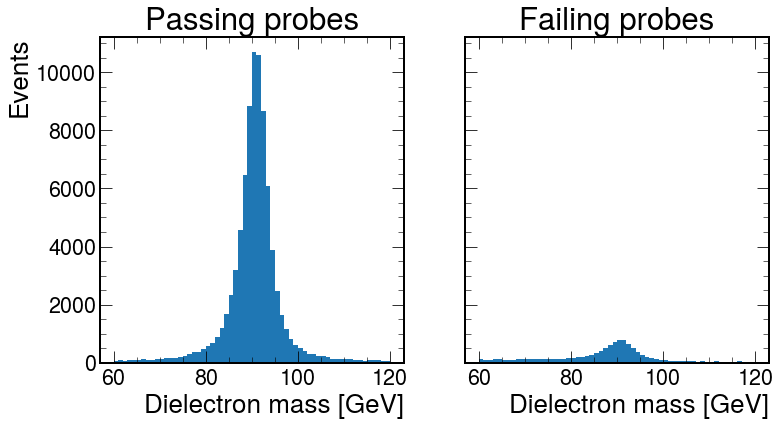

In [33]:
fig, (axp, axf) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
mbins = np.linspace(60, 120, 61)

axp.hist(passing_pairs_mass, bins=mbins)
axp.set_title("Passing probes")
axp.set_ylabel("Events")
axp.set_xlabel("Dielectron mass [GeV]")

axf.hist(failing_pairs_mass, bins=mbins)
axf.set_title("Failing probes")
axf.set_xlabel("Dielectron mass [GeV]")

Now make the same plot with low and high probe $p_{T}$ requirements.  How does the mass shape and relative peak height change?

**Plot the same distribution for electrons in real data**

Try repeating the exercise above using `dataevents` instead of `dyevents`. You'll notice the failing distribution's peak is hidden under a much larger amount of background. This is combinatorial background from random fake electrons combining with the tag to create a continuous falling invariant mass spectrum. Try applying some selections on the identification variables above, and see how they impact signal and background distributions.

To properly measure the peak height, a full analysis would have to subtract this background by fitting the pass and fail distributions.  If you got this far, try using [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to fit each distribution.

## Scale Factors

Tag and probe is the main method used derive the efficiencies that serve as inputs to the electron and photon *scale factors* (and most scale factors in general). The scale factors we will be using are defined as the ratio of the data efficieny to the Monte Carlo (MC) efficiency.


Scale factors for electrons and photons are applied as event weights. Scale factors serve to match the MC object efficiency (ID, reconstruction, etc.) to the observed data efficiency. **Q: Why could this correction be needed?**. Scale factors are accessible via [ROOT Histograms](https://twiki.cern.ch/twiki/bin/view/CMS/EgammaUL2016To2018#General_note_about_ID_SFs) and [JSONs](https://twiki.cern.ch/twiki/bin/viewauth/CMS/EgammaSFJSON). The JSON format works particularly well with NanaAOD and Coffea-based analyeses, so we will include a brief example of how to access the electron ID scale factors using the `correctionlib` package.

In [34]:
from correctionlib import CorrectionSet

evaluator = CorrectionSet.from_file(
    "/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/EGM/2018_UL/electron.json.gz"
)

Now that we have scale factors accessible, we need to apply them to our analysis! We already have a collection of Z candidates built (our tag and probe pairs), so we will use those. Normally you will not apply SFs to a tag and probe analyses, but this is just to serve as an example of how to apply scale factors to a Z candidate. 

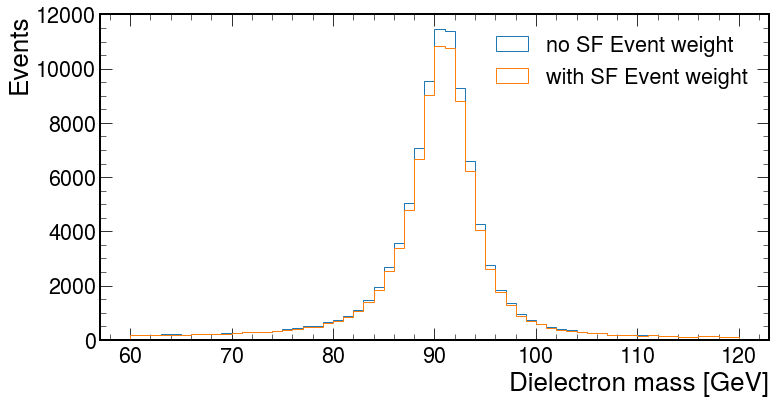

In [35]:
zcands = ak.flatten(zcands)
mass = (zcands.tag + zcands.probe).mass

# Get the ID scale factor for each electron in the pair
sfel1 = evaluator["UL-Electron-ID-SF"].evaluate(
    "2018", "sf", "Tight", zcands.tag.eta.to_numpy(), zcands.tag.pt.to_numpy()
)
sfel2 = evaluator["UL-Electron-ID-SF"].evaluate(
    "2018", "sf", "Loose", zcands.probe.eta.to_numpy(), zcands.probe.pt.to_numpy()
)

sftot = sfel1 * sfel2

# Apply the weights to the 'Good probes' Z mass peak
fig, ax = plt.subplots(figsize=(12, 6))
mbins = np.linspace(60, 120, 61)

ax.hist(mass, bins=mbins, label="no SF Event weight", histtype="step")
ax.hist(mass, bins=mbins, weights=sftot, label="with SF Event weight", histtype="step")
ax.set_ylabel("Events")
ax.set_xlabel("Dielectron mass [GeV]")
ax.legend()

Very similar! We need a better way to decide if the scale factors are relevant. Plots that directly show the differences between the two, such as ratio plots, may be useful.